In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [ ]:
dest = '/content/drive/MyDrive/HSE Final Project/to_train'
name = 'submit_7_abandoned.csv'

df = pd.read_csv(dest + '/' + name)
df.head()

,shop_id,item_id,month,year,date_block_num,item_cnt,item_price,prev_value,prev_value_year,stock_prev,stock_prev_year,shop_city,shop_category,item_category_id,digital,category_type,category_subtype,item_cnt_lag_2,item_cnt_lag_3,item_cnt_lag_4,item_cnt_lag_5,date_item_avg_item_cnt,shop_item_avg_item_cnt,cat_item_avg_item_cnt
0,0,19,1,2013,0,0,28.0,0,0,0.0,0.0,29,4,40,False,7,4,0,0,0,0,0.02222,0.0,0.02222
1,0,27,1,2013,0,0,2499.0,0,0,0.0,0.0,29,4,19,False,5,9,0,0,0,0,0.15550,0.0,0.05682
2,0,28,1,2013,0,0,549.0,0,0,0.0,0.0,29,4,30,False,5,49,0,0,0,0,0.17770,0.0,0.14120
3,0,29,1,2013,0,0,2499.0,0,0,0.0,0.0,29,4,23,False,5,18,0,0,0,0,0.08887,0.0,0.03738
4,0,32,1,2013,0,6,349.0,0,0,0.0,0.0,29,4,40,False,7,4,0,0,0,0,6.64500,8.0,1.31900


In [ ]:
df['shop_id'] = df['shop_id'].astype(np.int8)
df['item_id'] = df['item_id'].astype(np.int16)
df['month'] = df['month'].astype(np.int8)
df['year'] = df['year'].astype(np.int16)
df['date_block_num'] = df['date_block_num'].astype(np.int8)
df['item_cnt'] = df['item_cnt'].astype(np.int32)
df['prev_value'] = df['prev_value'].astype(np.int32)
df['prev_value_year'] = df['prev_value_year'].astype(np.int32)
df['shop_city'] = df['shop_city'].astype(np.int8)
df['shop_category'] = df['shop_category'].astype(np.int8)
df['item_category_id'] = df['item_category_id'].astype(np.int8)
df['digital'] = df['digital'].astype(np.bool_)
df['category_type'] = df['category_type'].astype(np.int8)
df['category_subtype'] = df['category_subtype'].astype(np.int8)
df['item_cnt_lag_2'] = df['item_cnt_lag_2'].astype(np.int32)
df['item_cnt_lag_3'] = df['item_cnt_lag_3'].astype(np.int32)
df['item_cnt_lag_4'] = df['item_cnt_lag_4'].astype(np.int32)
df['item_cnt_lag_5'] = df['item_cnt_lag_5'].astype(np.int32)

In [ ]:
# for col in df.columns[22:40]:
#     df[col] = df[col].astype(np.int32)

In [ ]:
df.shape

(10913804, 24)

In [ ]:
# df = df[df.date_block_num >= 12]
# df.reset_index(drop=True, inplace=True)
# df.shape

(6425094, 24)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10913804 entries, 0 to 10913803
Data columns (total 24 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   shop_id                 int8   
 1   item_id                 int16  
 2   month                   int8   
 3   year                    int16  
 4   date_block_num          int8   
 5   item_cnt                int32  
 6   item_price              float64
 7   prev_value              int32  
 8   prev_value_year         int32  
 9   stock_prev              float64
 10  stock_prev_year         float64
 11  shop_city               int8   
 12  shop_category           int8   
 13  item_category_id        int8   
 14  digital                 bool   
 15  category_type           int8   
 16  category_subtype        int8   
 17  item_cnt_lag_2          int32  
 18  item_cnt_lag_3          int32  
 19  item_cnt_lag_4          int32  
 20  item_cnt_lag_5          int32  
 21  date_item_avg_item_cnt  float

Due to the fact that we predict future, it makes no sense to shuffle the data

**Best Params:**

*   Max_depth: 8
*   Min_child_weight: 10
*   col_sample_by_tree: 0.8
*   eta: 0.05
*   n_estimators: 300
*   subsample: 0.9
*   gamma: 0.5


---


The best estimator across ALL searched params:
 XGBRegressor(colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=8,
             min_child_weight=10, n_estimators=300,
             objective='reg:squarederror', random_state=13, subsample=0.9,
             tree_method='gpu_hist', verbosity=2)

 The best score across ALL searched params:
 -2.0675645292926252

In [ ]:
# Indices for RandomizedSearchCV
index = df.index

condition_train = df.date_block_num < 33
train_indices = index[condition_train]

condition_valid = df.date_block_num == 33
valid_indices = index[condition_valid]

train_indices = train_indices.tolist()
valid_indices = valid_indices.tolist()

print(train_indices[-5:])
print(valid_indices[-5:])

[10675627, 10675628, 10675629, 10675630, 10675631]
[10913799, 10913800, 10913801, 10913802, 10913803]


In [ ]:
X = df.drop(['item_cnt'], axis=1)
y = df['item_cnt']

In [ ]:
del df

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# custom_cv = [(train_indices, valid_indices)]
params = {'learning_rate': [0.05, 0.1, 0.3, 0.5, 1], 
          'subsample': [0.6, 0.7, 0.8, 0.9, 1],
          'max_depth': [7, 8, 9, 10, 11],
          'min_child_weight': [5, 10, 15],
          'colsample_bytree': [0.8, 0.9, 1],
          'n_estimators': [300, 500, 700, 1000],
          'gamma': [0, 0.5, 1, 1.5, 2, 5]}

fit_params={"early_stopping_rounds": 30,
            "eval_metric": "rmse", 
            "eval_set": [(X.loc[valid_indices], y.loc[valid_indices])],
            "verbose": 2}

In [ ]:
splits = []
for block in [29, 30, 31, 32]:
    train_idxs = X[X.date_block_num < block].index.values
    test_idxs = X[X.date_block_num == block].index.values
    splits.append((train_idxs, test_idxs))

In [ ]:
# max_depth = 8
# min_child_weight = 5
# col_sample_by_tree = 0.9
# eta = 0.5
# n_estimators = 500
# subsample = 0.9
# gamma = 2

random_state = 13
verbosity = 2
gp = 'gpu_hist'
obj = 'reg:squarederror'

In [ ]:
xgbr = xgb.XGBRegressor(verbosity=verbosity,
                        objective=obj,
                        tree_method = gp,
                        random_state=random_state)

In [ ]:
# X_train = df[df.date_block_num < 33].drop(['item_cnt'], axis=1)
# y_train = df[df.date_block_num < 33]['item_cnt']
# X_valid = df[df.date_block_num == 33].drop(['item_cnt'], axis=1)
# y_valid = df[df.date_block_num == 33]['item_cnt']

In [ ]:
r_grid_xgbr = RandomizedSearchCV(xgbr, params,
                                 cv=splits,
                                 n_iter=150,
                                 scoring='neg_root_mean_squared_error',
                                 verbose=2)

In [ ]:
r_grid_xgbr.fit(X, y, **fit_params)

Выходные данные были обрезаны до нескольких последних строк (5000).
[76]	validation_0-rmse:4.35175
[78]	validation_0-rmse:4.34239
[80]	validation_0-rmse:4.33587
[82]	validation_0-rmse:4.32874
[84]	validation_0-rmse:4.33653
[86]	validation_0-rmse:4.33979
[88]	validation_0-rmse:4.3272
[90]	validation_0-rmse:4.30618
[92]	validation_0-rmse:4.29746
[94]	validation_0-rmse:4.29626
[96]	validation_0-rmse:4.30007
[98]	validation_0-rmse:4.29223
[100]	validation_0-rmse:4.29249
[102]	validation_0-rmse:4.29253
[104]	validation_0-rmse:4.27817
[106]	validation_0-rmse:4.26037
[108]	validation_0-rmse:4.25885
[110]	validation_0-rmse:4.25738
[112]	validation_0-rmse:4.24303
[114]	validation_0-rmse:4.24268
[116]	validation_0-rmse:4.23776
[118]	validation_0-rmse:4.2357
[120]	validation_0-rmse:4.23302
[122]	validation_0-rmse:4.23179
[124]	validation_0-rmse:4.23261
[126]	validation_0-rmse:4.23236
[128]	validation_0-rmse:4.23682
[130]	validation_0-rmse:4.23432
[132]	validation_0-rmse:4.22882
[134]	validation_0

RandomizedSearchCV(cv=[(array([      0,       1,       2, ..., 9789261, 9789262, 9789263]),
                        array([ 9789264,  9789265,  9789266, ..., 10013549, 10013550, 10013551])),
                       (array([       0,        1,        2, ..., 10013549, 10013550, 10013551]),
                        array([10013552, 10013553, 10013554, ..., 10242438, 10242439, 10242440])),
                       (array([       0,        1,        2, ..., 10242438, 10242439, 10242440]),
                        array([10242441, 10242442, 10242443, ..., 10456974, 10456975,...
                   estimator=XGBRegressor(objective='reg:squarederror',
                                          random_state=13,
                                          tree_method='gpu_hist', verbosity=2),
                   n_iter=150,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1],
                                        'gamma': [0, 0.5, 1, 1.5, 2, 5],
                                   

In [ ]:
print("\n The best estimator across ALL searched params:\n", r_grid_xgbr.best_estimator_)
print("\n The best score across ALL searched params:\n", r_grid_xgbr.best_score_)
print("\n The best parameters across ALL searched params:\n", r_grid_xgbr.best_params_)


 The best estimator across ALL searched params:
 XGBRegressor(colsample_bytree=0.8, gamma=0.5, learning_rate=0.05, max_depth=8,
             min_child_weight=10, n_estimators=300,
             objective='reg:squarederror', random_state=13, subsample=0.9,
             tree_method='gpu_hist', verbosity=2)

 The best score across ALL searched params:
 -2.0675645292926252

 The best parameters across ALL searched params:
 {'subsample': 0.9, 'n_estimators': 300, 'min_child_weight': 10, 'max_depth': 8, 'learning_rate': 0.05, 'gamma': 0.5, 'colsample_bytree': 0.8}


In [ ]:
xgbr = r_grid_xgbr.best_estimator_

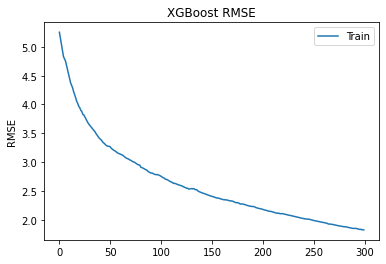

In [ ]:
import matplotlib.pyplot as plt

# retrieve performance metrics
results = xgbr.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# plot rmse
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
# ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

In [ ]:
import pickle

dest = '/content/drive/MyDrive/HSE Final Project/Models/'
file_name = 'xgb_reg_9 (best score data + r_search).pkl'

# save
pickle.dump(xgbr, open(dest + file_name, 'wb'))

In [ ]:
import pickle

dest = '/content/drive/MyDrive/HSE Final Project/Models/'
file_name = 'xgb_reg_9 (best score data + r_search).pkl'
# load
xgbr = pickle.load(open(dest + file_name, "rb"))

[18:22:52] INFO: /workspace/src/learner.cc:370: Parameter 'predictor' has been recovered from the saved model. It will be set to 'gpu_predictor' for prediction. To override the predictor behavior, explicitly set 'predictor' parameter as follows:
  * Python package: bst.set_param('predictor', [new value])
  * R package:      xgb.parameters(bst) <- list(predictor = [new value])
  * JVM packages:   bst.setParam("predictor", [new value])


In [ ]:
from sklearn.metrics import mean_squared_error

X_valid, y_valid = X.iloc[valid_indices], y.iloc[valid_indices]
y_pred = xgbr.predict(X_valid)
y_pred_rounded = np.around(y_pred)
mse = mean_squared_error(y_valid, y_pred)
mse_rd = mean_squared_error(y_valid, y_pred_rounded)

print('MSE: %.2f' % mse)
print('RMSE: %.2f' % (mse ** (0.5)))

print('MSE (rounded): %.2f' % mse_rd)
print('RMSE (rounded): %.2f' % (mse_rd ** (0.5)))

MSE: 3.32
RMSE: 1.82
MSE (rounded): 3.35
RMSE (rounded): 1.83


In [ ]:
dest = '/content/drive/MyDrive/HSE Final Project/to_test'
name = 'submit_7_test.csv'

test_df = pd.read_csv(dest + '/' + name)
test_df.head()

,shop_id,item_id,year,month,date_block_num,item_price,prev_value,prev_value_year,stock_prev,stock_prev_year,shop_city,shop_category,item_category_id,digital,category_type,category_subtype,item_cnt_lag_2,item_cnt_lag_3,item_cnt_lag_4,item_cnt_lag_5,date_item_avg_item_cnt,shop_item_avg_item_cnt,cat_item_avg_item_cnt
0,5,5037,2015,11,34,2599.0,0,1,0.0,2599.0,3,3,19,False,5,9,1,3,1,1,NaN,0.9287,1.951
1,5,5320,2015,11,34,0.0,0,0,0.0,0.0,3,3,55,False,9,2,0,0,0,0,NaN,NaN,NaN
2,5,5233,2015,11,34,1199.0,1,0,1199.0,0.0,3,3,19,False,5,9,3,1,0,2,NaN,1.4290,1.657
3,5,5232,2015,11,34,1199.0,0,0,0.0,0.0,3,3,23,False,5,18,0,1,0,0,NaN,0.3333,1.093
4,5,5268,2015,11,34,0.0,0,0,0.0,0.0,3,3,20,False,5,10,0,0,0,0,NaN,NaN,NaN


In [ ]:
test_df = test_df.fillna(0)

In [ ]:
test_df.shape

(214200, 23)

In [ ]:
test_df[['year', 'month']] = test_df[['month', 'year']]
test_df = test_df.rename(columns={'year': 'month',
                                  'month': 'year'})

In [ ]:
test_pred = xgbr.predict(test_df)
print(test_pred)

[-0.1064834  -0.00014472 -0.02336168 ...  0.02839088 -0.00958675
  0.00930065]


In [ ]:
name_sample = 'sample_submission.csv'

sample = pd.read_csv(dest + '/' + name_sample)
sample.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [ ]:
sample.item_cnt_month = np.around(test_pred)
sample.head()

,ID,item_cnt_month
0,0,-0.0
1,1,-0.0
2,2,-0.0
3,3,-0.0
4,4,0.0


In [ ]:
dest = '/content/drive/MyDrive/HSE Final Project/submissions/'
sample.to_csv(dest + 'submission #21 (old data + r_search).csv', index=False)

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt


def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

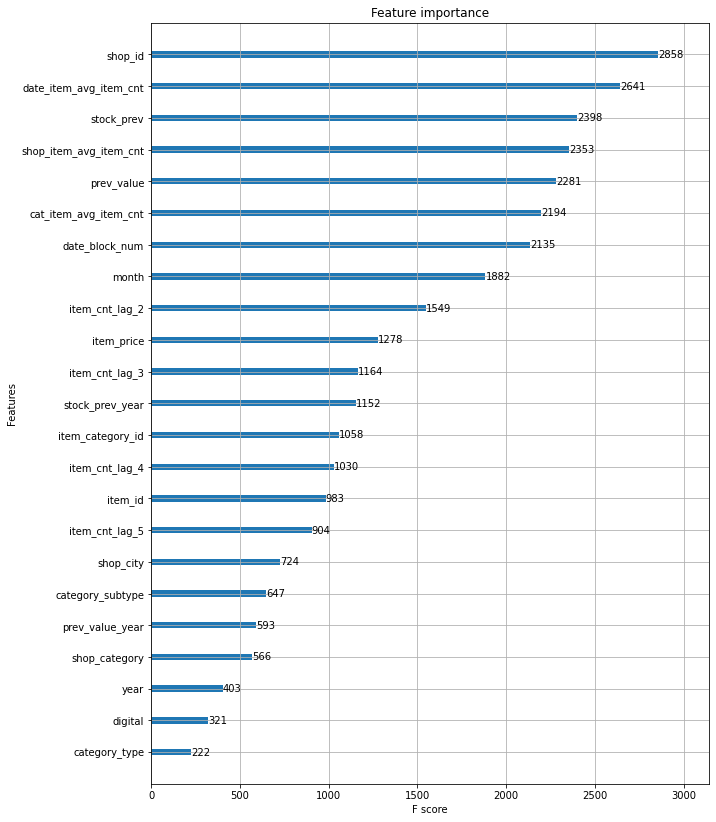

In [ ]:
plot_features(xgbr, (10, 14))